In [1]:
%pwd

'c:\\my-ml-project\\aws\\notebook'

In [2]:
import os
os.chdir("../")

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt

# Import Statistics libraries
from scipy import stats
from scipy.stats import norm

# Import Scikit-learn for Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# Import country code libraries
import pycountry

#Install plotly library
import plotly.io as pio
import plotly.express as px

In [4]:
df = pd.read_csv('artifacts/data_ingestion/ds_salaries.csv')


In [5]:
df.shape

(3755, 11)

In [6]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,3755.0,2022.373635,0.691448,2020.0,2022.0,2022.0,2023.0,2023.0
salary,3755.0,190695.571771,671676.500508,6000.0,100000.0,138000.0,180000.0,30400000.0
salary_in_usd,3755.0,137570.389880,63055.625278,5132.0,95000.0,135000.0,175000.0,450000.0
remote_ratio,3755.0,46.271638,48.589050,0.0,0.0,0.0,100.0,100.0


In [8]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [9]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

**Observation:** This dataset looks clean and has no missing value.

In [10]:
df.duplicated().sum()

np.int64(1171)

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
# Retrieve distinct values exist in each variable
for col in df.columns:
    print(f"{col}: {df[col].nunique()} distinct values")

work_year: 4 distinct values
experience_level: 4 distinct values
employment_type: 4 distinct values
job_title: 93 distinct values
salary: 815 distinct values
salary_currency: 20 distinct values
salary_in_usd: 1035 distinct values
employee_residence: 78 distinct values
remote_ratio: 3 distinct values
company_location: 72 distinct values
company_size: 3 distinct values


**Observation:** Few columns have a large number of categories, which will require a lot of memory to process and rare classes may not be very useful either. Hencer, those values could be regrouped into a limited number of categories or rare values could be relabelled as 'Other'.

In [13]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [14]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [15]:
df['experience_level'].unique()

array(['SE', 'MI', 'EN', 'EX'], dtype=object)

In [16]:
# abbreviated values are replaced with full form
df['experience_level'] = df['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid/Intermediate level'
})

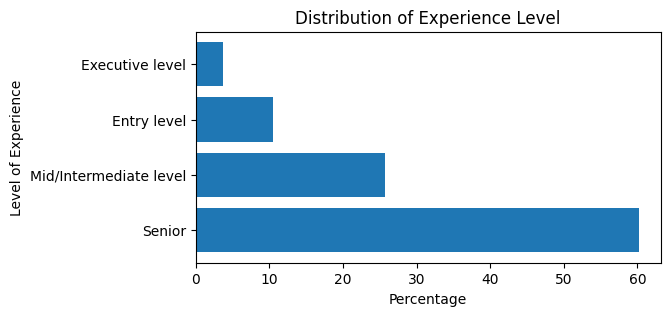

In [17]:
cat_pct = df['experience_level'].value_counts(normalize=True)*100
fig, ax = plt.subplots(figsize=(6, 3))
ax.barh(cat_pct.index, cat_pct.values)
ax.set_xlabel("Percentage")
ax.set_ylabel("Level of Experience")
ax.set_title("Distribution of Experience Level")
plt.show()

In [18]:
df['employment_type'].unique()

array(['FT', 'CT', 'FL', 'PT'], dtype=object)

In [19]:
# abbreviated values are replaced with full form
df['employment_type'] = df['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})

In [20]:
fig=px.pie(df.groupby(
    'employment_type',
    as_index=False).count().sort_values(by='salary_in_usd',
                                          ascending=False),
                                          names='employment_type',
                                          values='salary_in_usd',
                                          color='employment_type',
                                          hole=0.7,
                                          labels={'employment_type':'Employment level',
                                                  'salary_in_usd':'count'},
                                          template='seaborn',
                                          title='<b> Employment Types Proportion')
fig.update_layout(title_x=0.5)

In [21]:
df['job_title'].nunique()

93

**Observation:** The number of 'job-title' is as high as 93 which is neither necessaryn nor suitable for ML model training. Hence, 'job_title' values are regroped in to 10 broader job categories by putting similar job roles into same category.  

In [22]:
def broad_job_category(job_title):
    bi_analyst = ['BI Data Analyst', 'Business Data Analyst', 'BI Developer', 'BI Analyst', 
                  'Business Intelligence Engineer', 'BI Data Engineer', 'Power BI Developer']
    data_analyst = ['Data Analyst', 'Data Quality Analyst', 'Product Data Analyst', 'Data Analytics Lead' 
                    'Data Lead', 'Finance Data Analyst', 'Insight Analyst', 'Lead Data Analyst',
                    'Financial Data Analyst', 'Staff Data Analyst', 'Compliance Data Analyst',
                    'Data Analytics Engineer', 'Data Operations Analyst', 'Data Analytics Lead',
                    'Data Analytics Specialist', 'Data Analytics Consultant', 
                    'Marketing Data Analyst', 'Principal Data Analyst']
    data_scientist = ['Data Scientist', 'Applied Scientist', 'Research Scientist', 'Lead Data Scientist',
                      '3D Computer Vision Researcher', 'Deep Learning Researcher', 
                      'Staff Data Scientist', 'Data Science Lead', 'Data Science Consultant',
                      'Product Data Scientist', 'Data Science Tech Lead','Applied Data Scientist',
                      'Principal Data Scientist', 'Data Science Engineer', 'Data Modeler']
    ai_engineer = ['AI/Computer Vision Engineer', 'Computer Vision Software Engineer',
                   'AI Scientist', 'AI Programmer', 'AI Developer', 'Computer Vision Engineer',
                   'Deep Learning Engineer']
    ml_engineer = ['Machine Learning Engineer', 'ML Engineer', 'Lead Machine Learning Engineer',
                   'Principal Machine Learning Engineer', 'Machine Learning Scientist',
                   'MLOps Engineer', 'NLP Engineer','Applied Machine Learning Scientist', 
                   'Machine Learning Software Engineer', 'Applied Machine Learning Engineer', 
                   'Machine Learning Developer', 'Machine Learning Infrastructure Engineer']
    data_engr = ['Data Engineer', 'ETL Developer', 'Big Data Engineer', 'Azure Data Engineer',
                 'Lead Data Engineer', 'Analytics Engineer', 'Data Operations Engineer',
                 'Cloud Data Engineer', 'Marketing Data Engineer', 'ETL Engineer',
                 'Principal Data Engineer', 'Software Data Engineer', 'Software Data Engineer',
                 'Cloud Database Engineer', 'Data DevOps Engineer']
    data_arch = ['Data Architect', 'Big Data Architect', 'Data Infrastructure Engineer',
                 'Cloud Data Architect', 'Cloud Data Architect', 'Principal Data Architect']
    executive = ['Data Science Manager', 'Director of Data Science', 'Head of Data Science',
                 'Data Scientist Lead', 'Head of Machine Learning', 'Manager Data Management', 
                 'Data Analytics Manager', 'Data Manager']
    data_management = ['Data Specialist', 'Head of Data', 'Data Management Specialist', 
                       'Head of Data', 'Data Lead', 'Data Strategist', 'Machine Learning Manager']
    ai_ml_researcher = ['Machine Learning Researcher', 'Machine Learning Research Engineer',
                        'Research Engineer']
    
    if job_title in bi_analyst:
        return "BI Analyst"
    elif job_title in data_scientist:
        return "Data Scientist"
    elif job_title in ml_engineer:
        return "ML Engineer"
    elif job_title in data_engr:
        return "Data Engineer"
    elif job_title in data_arch:
        return "Data Architect"
    elif job_title in executive:
        return "DS/AI Executive"
    elif job_title in data_analyst:
        return "Data Analyst"
    elif job_title in ai_engineer:
        return "AI Engineer"
    elif job_title in data_management:
        return "Data Management"
    elif job_title in ai_ml_researcher:
        return "AI/ML Researcher"
    else:
        return job_title

# Apply the function to the 'job_title' column and create a new column 'job_category'
df['job_category'] = df['job_title'].apply(broad_job_category)

In [23]:
df['job_category'].value_counts()

job_category
Data Engineer                    736
Data Scientist                   707
Data Analyst                     439
ML Engineer                      323
DS/AI Executive                  117
Data Architect                    74
AI Engineer                       58
BI Analyst                        56
AI/ML Researcher                  42
Data Management                   30
Autonomous Vehicle Technician      2
Name: count, dtype: int64

**Observation:** 'Autonomous Vehicle Technician' seems to irreleveant category with 2 instances. Hence, those instances are removed.

In [24]:
df = df[~(df['job_category'] == 'Autonomous Vehicle Technician')]
df['job_category'].value_counts()

job_category
Data Engineer       736
Data Scientist      707
Data Analyst        439
ML Engineer         323
DS/AI Executive     117
Data Architect       74
AI Engineer          58
BI Analyst           56
AI/ML Researcher     42
Data Management      30
Name: count, dtype: int64

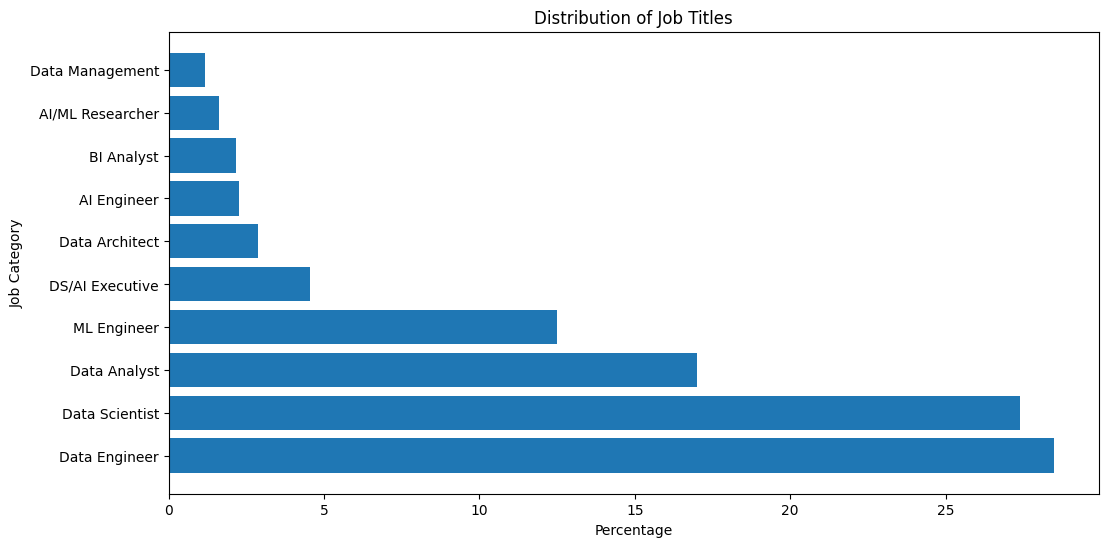

In [25]:
value_counts = df['job_category'].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(10, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Distribution of Job Titles')
plt.show()

In [26]:
df['employee_residence'].nunique()

78

In [27]:
print(df['company_location'].unique())

['ES' 'US' 'CA' 'DE' 'GB' 'NG' 'IN' 'HK' 'NL' 'CH' 'CF' 'FR' 'FI' 'UA'
 'IE' 'IL' 'CO' 'SG' 'AU' 'SE' 'SI' 'MX' 'BR' 'PT' 'RU' 'TH' 'GH' 'HR'
 'VN' 'EE' 'AM' 'BA' 'KE' 'GR' 'MK' 'LV' 'RO' 'PK' 'IT' 'MA' 'PL' 'AL'
 'AR' 'LT' 'AS' 'CR' 'IR' 'HU' 'AT' 'SK' 'CZ' 'TR' 'PR' 'DK' 'BO' 'PH'
 'BE' 'ID' 'EG' 'AE' 'LU' 'MY' 'HN' 'JP' 'DZ' 'IQ' 'CN' 'NZ' 'CL' 'MD'
 'MT']


In [28]:
# Function to convert ISO 3166 country code to country name
def country_code_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None  # Use None so it can be safely skipped later if needed

In [29]:
df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

In [31]:
# Step 1: Group your data
avg_salary_by_location = (
    df.groupby('company_location', as_index=False)['salary_in_usd'].mean()
)

# Step 2: Convert country names to ISO Alpha-3
def name_to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except:
        return None  # Skips invalid names like 'Remote'

# Apply conversion
avg_salary_by_location['iso_alpha'] = avg_salary_by_location['company_location'].apply(name_to_iso3)

# Drop rows with invalid or unrecognized country names
avg_salary_by_location = avg_salary_by_location.dropna(subset=['iso_alpha'])

# Step 3: Create the choropleth
fig = px.choropleth(
    avg_salary_by_location,
    locations='iso_alpha',                  # Use ISO Alpha-3 here
    color='salary_in_usd',
    hover_name='company_location',
    color_continuous_scale='Plasma',
    title='Average Salary by Company Location',
    labels={'salary_in_usd': 'Average Salary (USD)'},
    projection='equirectangular'
)

fig.update_layout(title_x=0.5)
fig.show()

In [32]:
df['remote_ratio'] = df['remote_ratio'].astype(str)
df['remote_ratio'] = df['remote_ratio'].replace(
    {'0': 'On site',
     '50': 'Hybride',
     '100': 'Remote'}
)
df['remote_ratio'].value_counts()

remote_ratio
Remote     1211
On site    1185
Hybride     186
Name: count, dtype: int64

In [33]:
df['company_size'] = df['company_size'].replace(
    {'L': 'Large',
    'M': 'Medium',
    'S': 'Small'}
)

In [34]:
df['employee_residence'].value_counts().head(10)

employee_residence
United States     1893
United Kingdom     150
Canada              81
India               70
Germany             47
Spain               47
France              37
Portugal            18
Brazil              18
Netherlands         15
Name: count, dtype: int64

In [35]:
df.shape

(2582, 12)

In [42]:
# Put rare countries in 'employee_residency' into 'other' category
threshold = 30
val_count = df['employee_residence'].value_counts()
top_index = val_count[val_count > threshold].index

df['employee_residence_top'] = df['employee_residence'].apply(
    lambda x: x if x in top_index or x == 'Australia' else 'Other'
)

df['employee_residence_top'].value_counts()

employee_residence_top
United States     1893
Other              246
United Kingdom     150
Canada              81
India               70
Spain               47
Germany             47
France              37
Australia           11
Name: count, dtype: int64

In [39]:
# Select top 9 categories in company_location and remaining in other category
top_n = 9
top_n_index = df['company_location'].value_counts().nlargest(9).index
df['company_location_top'] = df['company_location'].apply(
    lambda x: 'Other' if x not in top_n_index else x
)
df['company_location_top'].value_counts()

company_location_top
United States     1929
Other              197
United Kingdom     155
Canada              83
India               57
Germany             55
Spain               44
France              33
Brazil              15
Australia           14
Name: count, dtype: int64

**Observation:** There are countries observed but most of them appeared rarely. Hence, RareLableEncoder() class class can be used to encode 'company_location' and 'employee_residence' variables.

In [95]:
def adjust_salary(data:pd.DataFrame):
    year = data['work_year']
    currency = data['salary_currency']
    salary_usd = data['salary_in_usd']
    # Inflation rates
    us_inflation_rates = {2019: 0.018, 2020: 0.012, 2021: 0.047, 
                        2022: 0.08, 2023: 0.041, 2024: 0.029, 2025: 0.02}
    global_inflation_rates = {2019: 0.019, 2020: 0.019, 2021: 0.035, 
                            2022: 0.057, 2023: 0.049, 2024: 0.058, 2025: 0.036}
    adjsuted_salary = salary_usd
    for y in range(year, 2025):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]
        adjsuted_salary *= (1+inflation_rate)
        adjsuted_salary = int(round(adjsuted_salary, 0))

    return adjsuted_salary
df['inflation_adj_salary'] = df.apply(adjust_salary, axis=1)


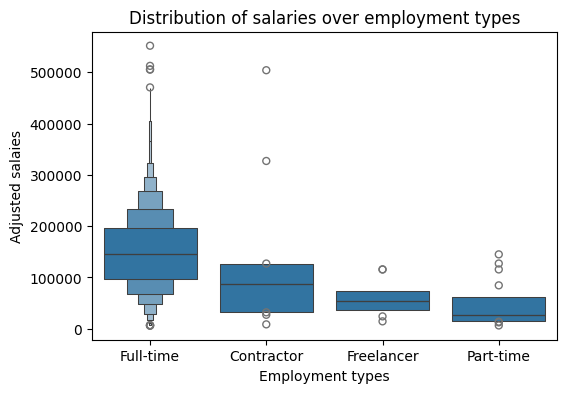

In [96]:
plt.figure(figsize=(6, 4))
sns.boxenplot(data= df, x='employment_type', y='inflation_adj_salary')
plt.title("Distribution of salaries over employment types")
plt.xlabel("Employment types")
plt.ylabel("Adjusted salaies")
plt.show()

**Observation:** both 'salary' and 'salary_in_usd' provide similar information and 'salary_currency' seems irrelevant. Hence, 'salary' and 'salary_currency' could better be dropped from the data frame, whereas 'salary_in_usd' is selected as the target variable. 

In [97]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'job_category',
       'employee_residence_top', 'company_location_top',
       'inflation_adj_salary'],
      dtype='object')

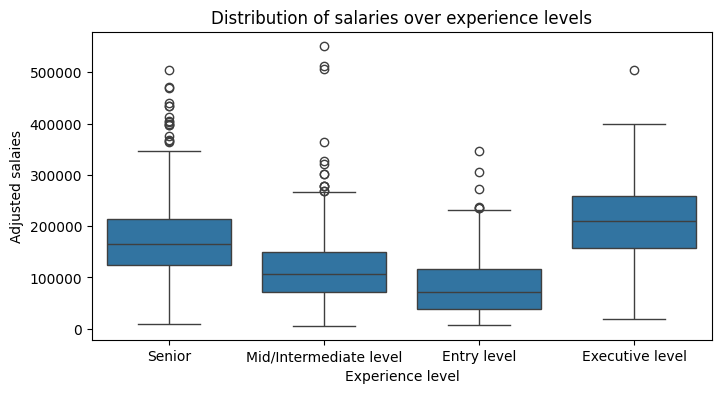

In [98]:
plt.figure(figsize=(8, 4))
sns.boxplot(data= df, x='experience_level', y='inflation_adj_salary')
plt.title("Distribution of salaries over experience levels")
plt.xlabel("Experience level")
plt.ylabel("Adjusted salaies")
plt.show()

inflation_adj_salary: mu = 149674.58, sigma = 74446.89
inflation_adj_salary: Skewness: 0.68
inflation_adj_salary: Kurtosis: 1.23


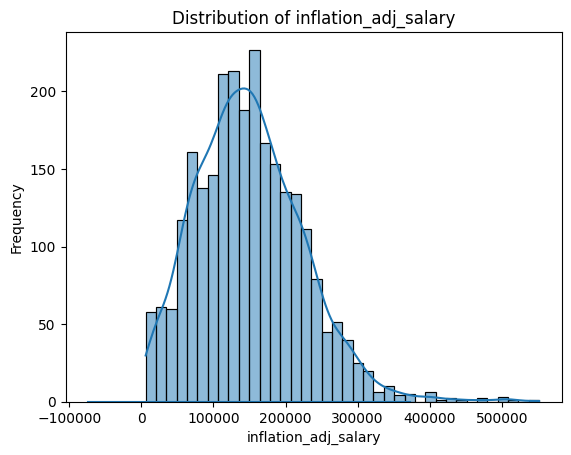

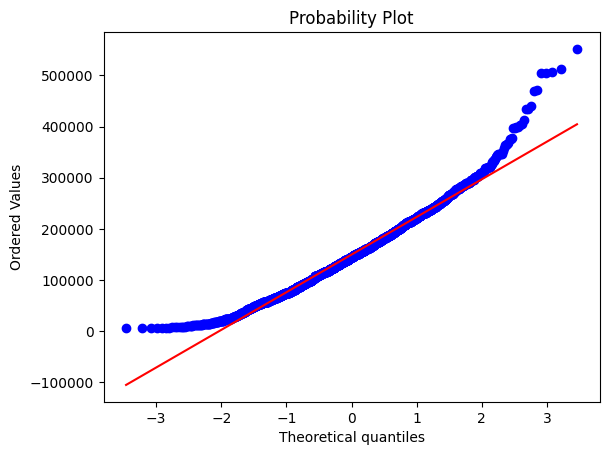

In [99]:
import numpy as np
# Create a list of the columns to analyze
columns = ['inflation_adj_salary']

# Loop over the columns and plot the distribution of each variable
for col in columns:
    # Plot the distribution of the data
    sns.histplot(df[col], kde=True)

    # Fit a normal distribution to the data
    (mu, sigma) = stats.norm.fit(df[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

    # Calculate the skewness and kurtosis of the data
    print('{}: Skewness: {:.2f}'.format(col, df[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, df[col].kurt()))

    # Add the fitted normal distribution to the plot
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')

    # Add labels and title to the plot
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))

    # Plot the QQ-plot
    fig = plt.figure()
    stats.probplot(df[col], plot=plt)

plt.show()

C:\Users\abdul\AppData\Local\Temp\ipykernel_20140\1143222111.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




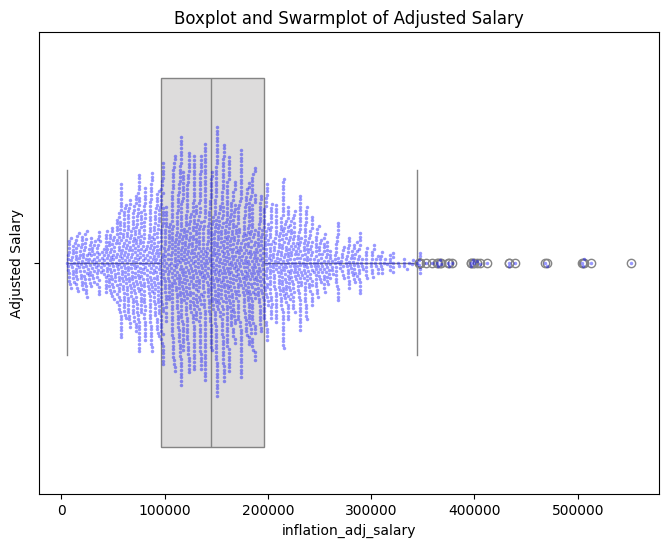

,inflation_adj_salary
count,2582.00
mean,149674.58
std,74461.31
min,6021.00
25%,96407.00
50%,144611.00
75%,195961.00
max,551607.00


In [100]:
# apply formatting to describe method for 'adjusted_salary' column
formatted_data = df.loc[:, 'inflation_adj_salary'].describe().apply(lambda x: f'{x:.2f}')

# create boxplot and swarmplot for 'adjusted_salary' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['inflation_adj_salary'], palette='coolwarm')
sns.swarmplot(x=df['inflation_adj_salary'], color='blue', alpha=0.4, size=2.5)
plt.ylabel('Adjusted Salary')
plt.title('Boxplot and Swarmplot of Adjusted Salary')
plt.show()

# apply styling to formatted data
styled_data = formatted_data.to_frame().style \
    .background_gradient(cmap='Blues') \
    .set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# display styled data
display(styled_data)

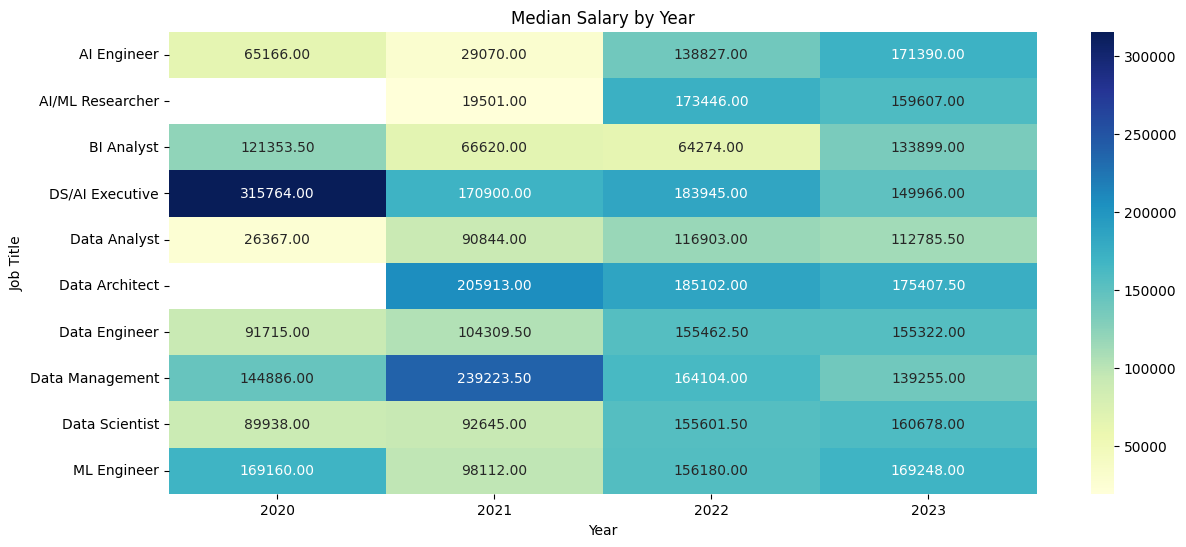

In [101]:
df_copy = df.copy(deep=True)

#  Median salary by job title
pivot_table = df_copy.pivot_table(values='inflation_adj_salary', index='job_category', columns='work_year', aggfunc='median')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Median Salary by Year')
plt.xlabel('Year')
plt.ylabel('Job Title')
plt.show()

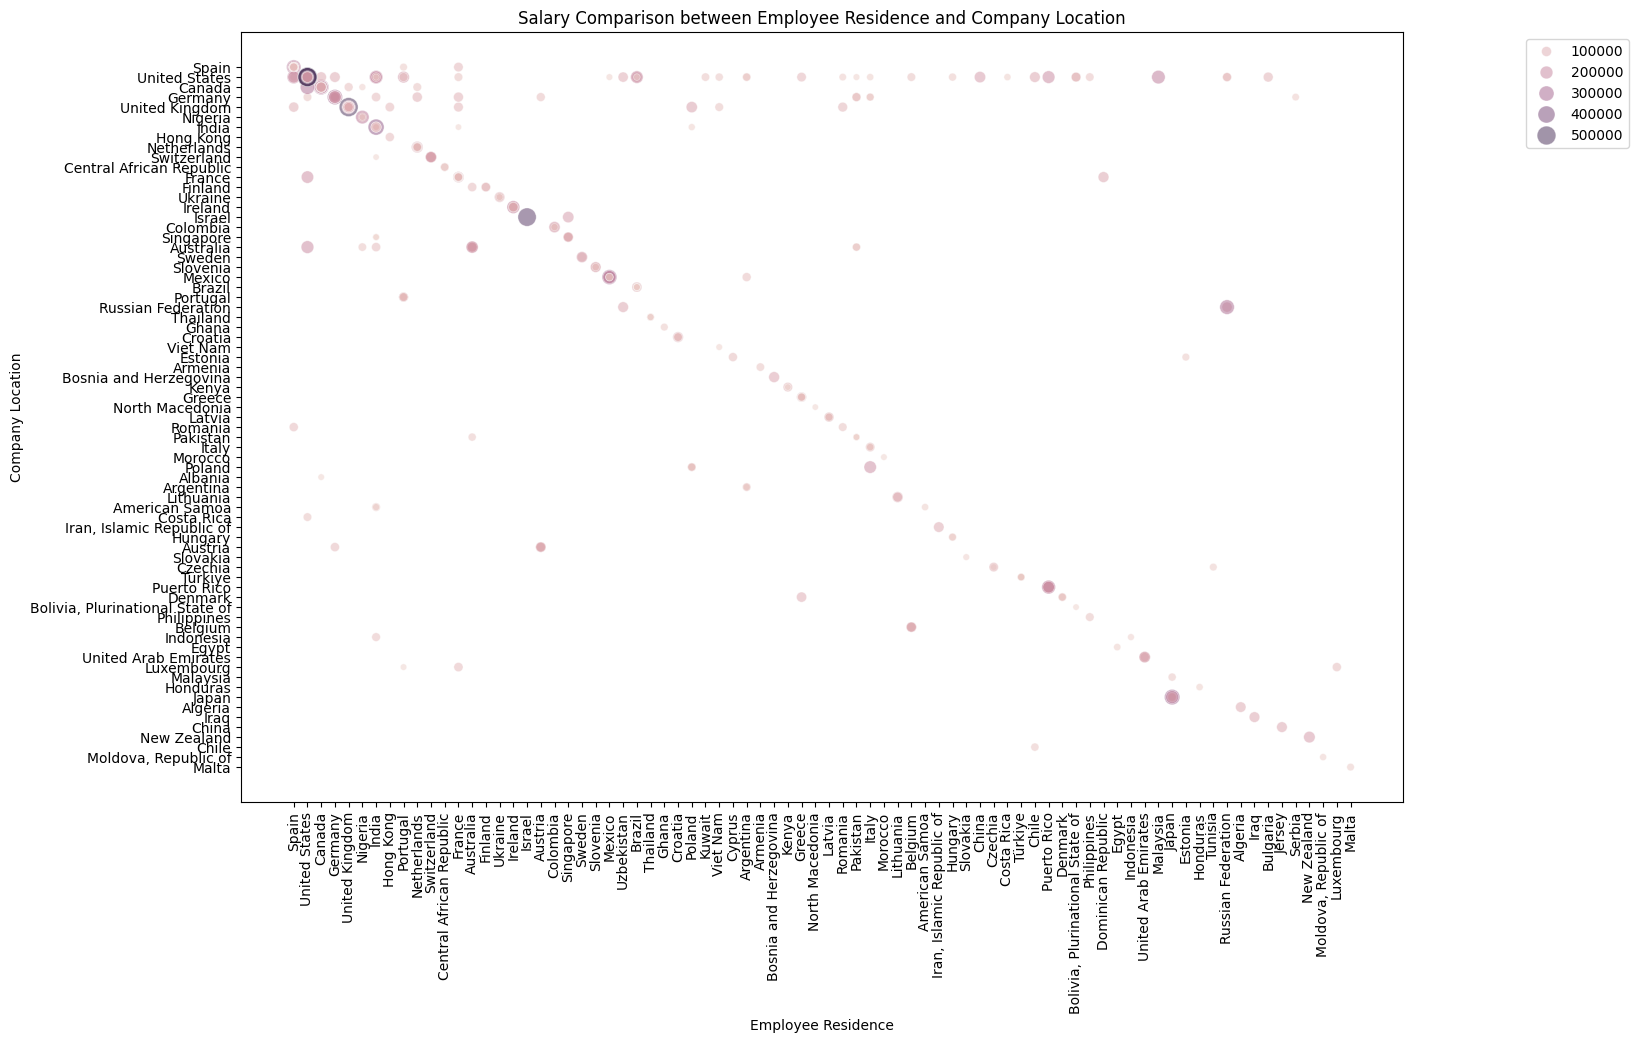

In [102]:
# Salary comparison between employee residence and company location
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_copy, x='employee_residence', y='company_location', 
                hue='inflation_adj_salary', size='inflation_adj_salary', 
                sizes=(20, 200), alpha=0.5)
plt.title('Salary Comparison between Employee Residence and Company Location')
plt.xlabel('Employee Residence')
plt.ylabel('Company Location')
plt.xticks(rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

**Observation:** Though years are usually expressed as numeric. For training ML models, \
it could better be converted to categorical values to avoid misleading association with \
the target variable

In [103]:
df['work_year'] = df['work_year'].astype('category')
df['work_year'].value_counts()

work_year
2023    1155
2022    1125
2021     227
2020      75
Name: count, dtype: int64

correlation_matrix = processed_df.corr()

#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

corr = processed_df.corr()
target_corr = corr['adjusted_salary'].drop('adjusted_salary')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

#Graph II
# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Salary')
plt.show()

In [104]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'job_category',
       'employee_residence_top', 'company_location_top',
       'inflation_adj_salary'],
      dtype='object')

**Observation:** Certain columns are either redundant, such as 'job_title', 'salary', 'salary_in_usd', 'company_location', 'employee_residency' due to the creation of new features, or less relevant, such as  salary_currency. Hence, these columns should better be dropped.

In [105]:
cols_to_drop = ['job_title', 'salary', 'salary_currency',
                        'salary_in_usd', 'employee_residence',
                        'company_location']
df_transform = df.drop(columns = cols_to_drop, axis=1)

In [106]:
q1 = df_transform['inflation_adj_salary'].quantile(0.25)
q3 = df_transform['inflation_adj_salary'].quantile(0.75)
iqr = q3 - q1
df_outlier_free = df_transform[~((df_transform['inflation_adj_salary'] < (q1-1.5*iqr)) | (
    df_transform['inflation_adj_salary'] > (q3+1.5*iqr)))]

In [107]:
df_outlier_free.shape

(2550, 9)

In [108]:
df_outlier_free.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2550 entries, 0 to 3754
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   work_year               2550 non-null   category
 1   experience_level        2550 non-null   object  
 2   employment_type         2550 non-null   object  
 3   remote_ratio            2550 non-null   object  
 4   company_size            2550 non-null   object  
 5   job_category            2550 non-null   object  
 6   employee_residence_top  2550 non-null   object  
 7   company_location_top    2550 non-null   object  
 8   inflation_adj_salary    2550 non-null   int64   
dtypes: category(1), int64(1), object(7)
memory usage: 182.0+ KB


In [110]:
df_outlier_free.columns

Index(['work_year', 'experience_level', 'employment_type', 'remote_ratio',
       'company_size', 'job_category', 'employee_residence_top',
       'company_location_top', 'inflation_adj_salary'],
      dtype='object')

inflation_adj_salary: mu = 146447.38, sigma = 68768.69
inflation_adj_salary: Skewness: 0.68
inflation_adj_salary: Kurtosis: 1.23


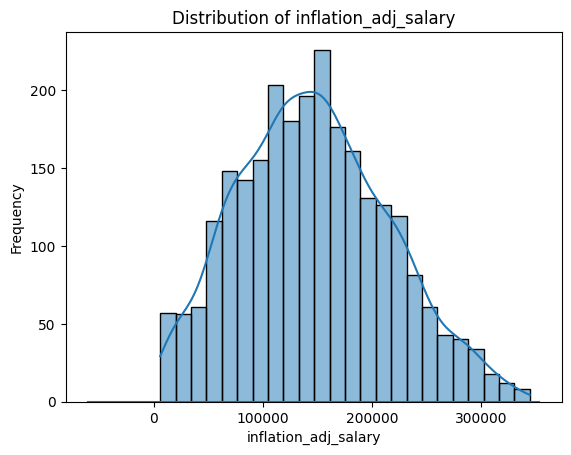

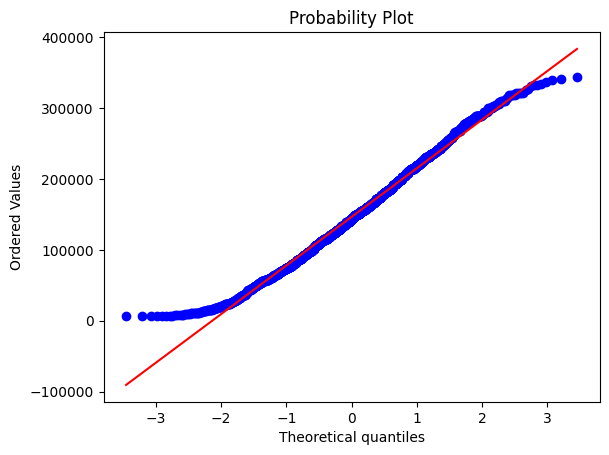

In [111]:
# Create a list of the columns to analyze
columns = ['inflation_adj_salary']

# Loop over the columns and plot the distribution of each variable
for col in columns:
    # Plot the distribution of the data
    sns.histplot(df_outlier_free[col], kde=True)

    # Fit a normal distribution to the data
    (mu, sigma) = stats.norm.fit(df_outlier_free[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

    # Calculate the skewness and kurtosis of the data
    print('{}: Skewness: {:.2f}'.format(col, df_transform[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, df_transform[col].kurt()))

    # Add the fitted normal distribution to the plot
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')

    # Add labels and title to the plot
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))

    # Plot the QQ-plot
    fig = plt.figure()
    stats.probplot(df_outlier_free[col], plot=plt)

plt.show()

In [112]:
df_outlier_free.columns

Index(['work_year', 'experience_level', 'employment_type', 'remote_ratio',
       'company_size', 'job_category', 'employee_residence_top',
       'company_location_top', 'inflation_adj_salary'],
      dtype='object')

In [121]:
df_outlier_free['employee_residence_top'].unique()

array(['Spain', 'United States', 'Canada', 'Germany', 'United Kingdom',
       'Other', 'India', 'France'], dtype=object)

In [122]:
df_outlier_free['company_location_top'].unique()

array(['Spain', 'United States', 'Canada', 'Germany', 'United Kingdom',
       'Other', 'India', 'France', 'Australia', 'Brazil'], dtype=object)